# Conditional image synthesis with AC-GANs (Auxiliary Classifier GANs)


## 0. Imports

In [ ]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist, fashion_mnist, cifar10
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

## 1. Utils (plots and metrics)

### 1.1 Plots

In [ ]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [ ]:
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

### 1.2 Metrics of quality, diversity, discriminability (description + Torch)

After doing visual quality control, it is a good idea to quantify the quality
of the generated images using specific metrics. Some popular metrics include
the Mean Absolute Error (MAE), the Peak Signal-to-Noise Ratio (PSNR) and
the Structural Similarity index (SSIM):

* MAE = $\displaystyle \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m \vert T_{ij} - G_{ij} \vert $

* PSNR = $\displaystyle -10 \log_{10} \left( \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m (T_{ij} - G_{ij})^2 \right) $

* SSIM = $\displaystyle  \frac{(2 \mu_T \mu_G + C_1)(2 \sigma_{TG} + C_2)}{(\mu_T^2 +
\mu_G^2 + C_1)(\sigma_T^2 + \sigma_G^2 + C_2)} $ where:

    * $\mu$ and $\sigma$ are the mean value and standard deviation of an image respectively, and
    * $C_1$ and $C_2$ are two positive constants (one can take $C_1=0.01$ and $C_2=0.03$).

The [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
is simply the mean of each absolute value of the difference between
the true pixel ($T_{ij}$) and the generated pixel ($G_{ij}$).
The lower, the better. Minimum value is 0.

The [peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
is a function of the mean squared error and allows for comparing
images encoded with different scales. We simplified its formula in our case.
The higher, the better. Maximum value is $+\infty$.

The [structural similarity index](https://en.wikipedia.org/wiki/Structural_similarity)
is a weighted combination of the luminance, the contrast and the structure.
The higher, the better. Maximum value is 1.

For those interested, you can find [here](https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
a reference to better understand the differences between these metrics.

We provide an implementation for each metric with the functions below.

In [ ]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.
    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.
    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.
    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator
    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

In [ ]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.
    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()

In [ ]:
def evaluate_generator(generator):
    """Evaluate a generator.
    Args:
        generator: (GeneratorUNet) neural network generating T2-w images
    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    for i, batch in enumerate(train_loader):

        # Inputs T1-w and T2-w
        real_t1 = Variable(batch["T1"].type(Tensor), requires_grad=False)
        real_t2 = Variable(batch["T2"].type(Tensor), requires_grad=False)
        fake_t2 = Variable(generator(real_t1), requires_grad=False)

        mae = mean_absolute_error(real_t2, fake_t2).item()
        psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
        ssim = structural_similarity_index(real_t2, fake_t2).item()

        res_train.append([mae, psnr, ssim])

    for i, batch in enumerate(test_loader):

        # Inputs T1-w and T2-w
        real_t1 = Variable(batch["T1"].type(Tensor), requires_grad=False)
        real_t2 = Variable(batch["T2"].type(Tensor), requires_grad=False)
        fake_t2 = Variable(generator(real_t1), requires_grad=False)

        mae = mean_absolute_error(real_t2, fake_t2).item()
        psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
        ssim = structural_similarity_index(real_t2, fake_t2).item()

        res_test.append([mae, psnr, ssim])

    df = pd.DataFrame([
        pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
        pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
    ], index=['Training set', 'Test set']).T
    return df

### 1.3 Metrics (keras)

#### 1.3.1 Inception Score

In [ ]:
from math import floor
from numpy import ones, expand_dims, log, mean, std, exp, asarray

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize

from random import shuffle


# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = np.floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = int(i * n_part), int((i+1) * n_part)

		subset = images[ix_start:ix_end]
		subset = subset.astype('float32')
  
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
  
		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
  
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)
  
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
  
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
  
		# store
		scores.append(is_score)
  
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [ ]:
# load cifar10 images
(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(images)
print('loaded', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)

loaded (50000, 32, 32, 3)


#### 1.3.3 Inception Score (last try)

In [ ]:
!git clone https://github.com/hvy/chainer-inception-score/tree/08f8b4eab533df6bdf4ae3b892bee6fb71039f1b

!python download.py --outfile inception_score.model

Cloning into '08f8b4eab533df6bdf4ae3b892bee6fb71039f1b'...
fatal: repository 'https://github.com/hvy/chainer-inception-score/tree/08f8b4eab533df6bdf4ae3b892bee6fb71039f1b/' not found
python3: can't open file 'download.py': [Errno 2] No such file or directory


In [ ]:
import numpy as np
from chainer import serializers, datasets
from inception_score import Inception, inception_score

model = Inception()
serializers.load_hdf5('inception_score.model', model)

train, test = datasets.get_cifar10(ndim=3, withlabel=False, scale=255.0)
mean, std = inception_score(model, np.concatenate(train, test))

print('Inception score mean:', mean)
print('Inception score std:', std)

ModuleNotFoundError: ignored

## 2. introduction : Fashion_MNIST

### 2.1 implementation

In [ ]:
class AcGan_fashion():
  def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=100):
    self.input_shape = (nb_rows, nb_columns, nb_channels)
    self.nb_classes = nb_classes
    self.noise_dim = noise_dim
    self.discriminator = Sequential()
    self.generator = Sequential()
    self.model = None
    self.optimizer = Adam(0.0002, 0.5)
    self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']


  def instanciate_discriminator(self) :
    self.discriminator.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.input_shape, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))

    self.discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    self.discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))

    self.discriminator.add(Flatten())

    self.discriminator.summary()

    # Extract feature representation
    img_real = Input(shape=self.input_shape)
    features = self.discriminator(img_real)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid")(features)
    label = Dense(self.nb_classes+1, activation="softmax")(features)

    self.discriminator = Model(img_real, [validity, label])
    self.discriminator.compile(loss=self.losses,
      optimizer=self.optimizer,
      metrics=['accuracy'])



  def instanciate_generator(self):
    self.generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.noise_dim))
    self.generator.add(Reshape((7, 7, 128)))
    self.generator.add(BatchNormalization(momentum=0.8))
    self.generator.add(UpSampling2D())

    self.generator.add(Conv2D(128, kernel_size=3, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))
    self.generator.add(UpSampling2D())

    self.generator.add(Conv2D(64, kernel_size=3, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))

    self.generator.add(Conv2D(self.input_shape[2], kernel_size=3, padding='same'))
    self.generator.add(Activation("tanh"))

    self.generator.summary()

    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

    model_input = multiply([noise, label_embedding])
    img_gen = self.generator(model_input)

    self.generator = Model([noise, label], img_gen)



  def instanciate_combined_model(self):
    # The generator takes noise and the target label as input and generates the corresponding digit of that label
    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    img_gen = self.generator([noise, label])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated image as input and determines validity and the label of that image
    valid, target_label = self.discriminator(img_gen)

    # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
    self.model = Model([noise, label], [valid, target_label])
    self.model.compile(loss=self.losses,
        optimizer=self.optimizer)



  def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):
    # Configure inputs
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Loss output
    g_loss_epochs = np.zeros((epochs, 1))
    d_loss_epochs = np.zeros((epochs, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        fake_labels = 10 * np.ones(img_labels.shape)

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        #show the final losses
        g_loss_epochs[epoch] = g_loss[0]
        d_loss_epochs[epoch] = d_loss[0]

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            # Plot the progress
            print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            #do not save model
            #self.save_model()
            self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

    return g_loss_epochs, d_loss_epochs
 



  #row, cols to be sampled
  def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
      r, c = smp_rows, smp_cols
      noise = np.random.normal(0, 1, (r * c, self.noise_dim))
      sampled_labels = np.array([num for _ in range(r) for num in range(c)])
      gen_imgs = self.generator.predict([noise, sampled_labels])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      #plt.figure(figsize=fig_size)
      fig, axs = plt.subplots(r, c, figsize=fig_size)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      if save_img:
          fig.savefig("../images/%d.png" % epoch)
      else:
          #plt.figure(figsize=fig_size)
          plt.show()
      plt.close()



  def sample_single_image(self, noise, label):
      gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')



  def save(model, model_name):
      model_path = "../saved_model/%s.json" % model_name
      weights_path = "../saved_model/%s_weights.hdf5" % model_name
      options = {"file_arch": model_path,
                  "file_weight": weights_path}
      json_string = model.to_json()
      #
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

      save(self.generator, "generator")
      save(self.discriminator, "discriminator")

### 2.2 Loading data and Training

In [ ]:
(X_train, y_train), (_, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#label dictionary
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
ac_gan = AcGan_fashion(nb_rows=28, nb_columns=28, nb_channels=1, nb_classes=len(label_dict), noise_dim=100)

In [ ]:
ac_gan.instanciate_discriminator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0

In [ ]:
ac_gan.instanciate_generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)      

In [ ]:
ac_gan.instanciate_combined_model()

Epoch: 0 [D loss: 3.358998, acc.: 32.00%, op_acc: 20.50%] [G loss: 3.097411]


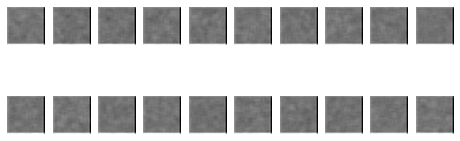

Epoch: 200 [D loss: 2.000190, acc.: 50.50%, op_acc: 48.00%] [G loss: 2.482871]


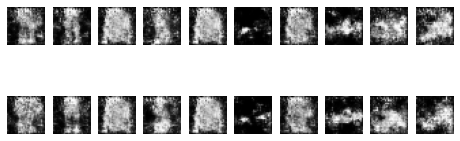

Epoch: 400 [D loss: 1.871403, acc.: 59.50%, op_acc: 42.00%] [G loss: 2.071608]


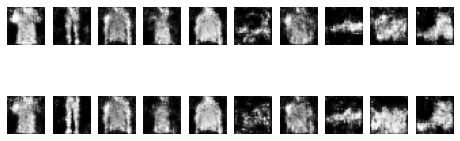

Epoch: 600 [D loss: 1.811063, acc.: 50.00%, op_acc: 47.50%] [G loss: 1.917936]


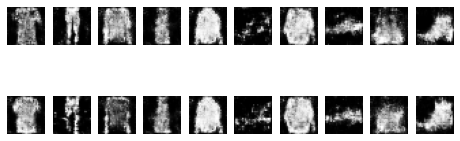

Epoch: 800 [D loss: 1.876017, acc.: 54.00%, op_acc: 41.00%] [G loss: 1.876779]


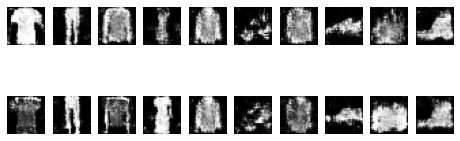

Epoch: 1000 [D loss: 1.931799, acc.: 54.00%, op_acc: 38.50%] [G loss: 1.962133]


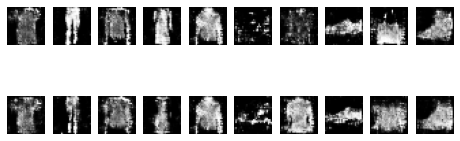

Epoch: 1200 [D loss: 1.872688, acc.: 49.50%, op_acc: 46.00%] [G loss: 1.960614]


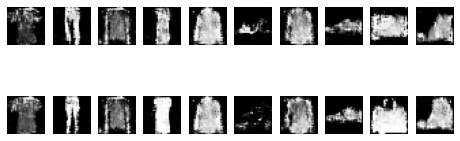

Epoch: 1400 [D loss: 2.022070, acc.: 51.00%, op_acc: 40.50%] [G loss: 1.772044]


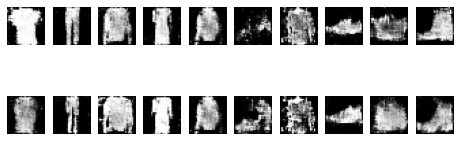

Epoch: 1600 [D loss: 1.248583, acc.: 83.50%, op_acc: 66.50%] [G loss: 1.961113]


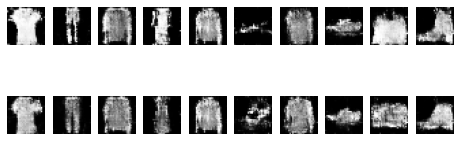

Epoch: 1800 [D loss: 1.715362, acc.: 60.50%, op_acc: 48.00%] [G loss: 1.766383]


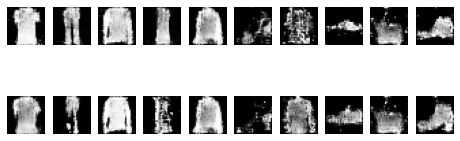

In [ ]:
g_loss, d_loss = ac_gan.train(X_train, y_train, epochs=2000, batch_size=100, sample_interval=200)

### 2.3 Loss evolution

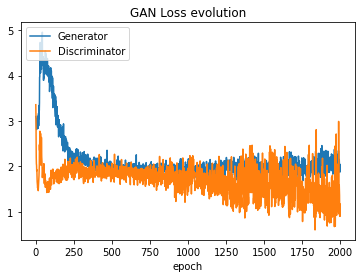

In [ ]:
plot_gan_losses(g_loss, d_loss)

### 2.4 Examples of generated fake images



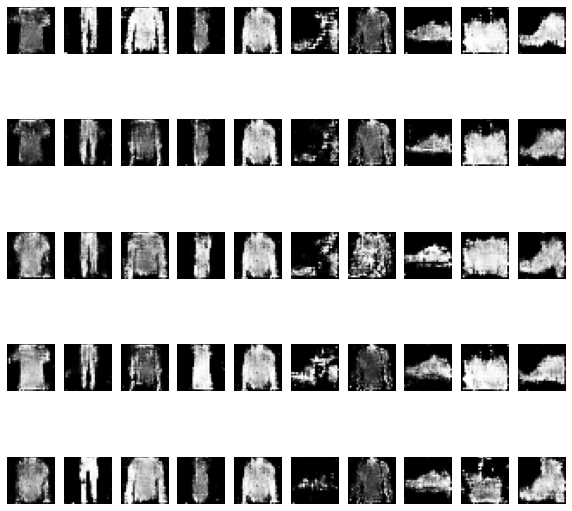

In [ ]:
ac_gan.sample_images(0, smp_rows=5, smp_cols=10, save_img=False, fig_size=(10, 10))

### 2.5 Check if a generated image is a copy of k-nearest neighbors

In [ ]:
id_label_sample = 8
#yet another noise sample
yan = np.random.normal(0, 1, (1, 100))
img_smp = ac_gan.generator.predict([yan, np.array(id_label_sample).reshape(1, )])[0, :, :, 0]
img_smp = img_smp*0.5 + 0.5

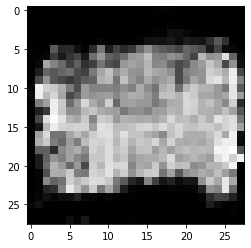

In [ ]:
#original image
plt.imshow(img_smp, cmap='gray')

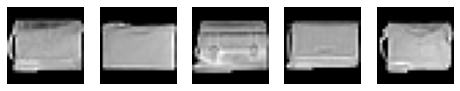

In [ ]:
plot_n_closest(img_smp, 8, X_train, 5, fig_size=(8, 8))

## 3. Application (32x32) : Cifar10

### 3.1 Adapted class of AC-GANs (conv size etc)

In [ ]:
!pip install --upgrade gupload

from pydrive.auth import GoogleAuth
from google.colab import auth

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
auth.authenticate_user()

In [ ]:
def noisy_LeakyReLU_1(x):
  return K.relu(x, alpha=0.2) #+ K.random_normal(shape=tf.shape(x), mean=0, stddev=0.03)

def noisy_LeakyReLU_2(x):
  return K.relu(x, alpha=0.2) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_sigmoid(x):
  return K.sigmoid(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_softmax(x):
  return K.softmax(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_tanh(x):
  return K.tanh(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_ReLU(x):
    return K.relu(x, alpha=0.0) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)


get_custom_objects().update({'noisy_LeakyReLU_1': Activation(noisy_LeakyReLU_1)})
get_custom_objects().update({'noisy_LeakyReLU_2': Activation(noisy_LeakyReLU_2)})
get_custom_objects().update({'noisy_sigmoid': Activation(noisy_sigmoid)})
get_custom_objects().update({'noisy_tanh': Activation(noisy_tanh)})
get_custom_objects().update({'noisy_softmax': Activation(noisy_softmax)})
get_custom_objects().update({'noisy_ReLU': Activation(noisy_ReLU)})

In [ ]:
class AcGan_Cifar():
  def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=110):
    self.input_shape = (nb_rows, nb_columns, nb_channels)
    self.nb_classes = nb_classes
    self.noise_dim = noise_dim
    self.discriminator = Sequential()
    self.generator = Sequential()
    self.model = None
    self.optimizer = Adam(0.0001, 0.5, 0.999)
    self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']


  def instanciate_discriminator(self) :
    self.discriminator.add(Conv2D(16, kernel_size=3, strides=2, 
                                  input_shape=self.input_shape, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))

    self.discriminator.add(Conv2D(32, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(64, kernel_size=3, strides=2, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))    
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(128, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(256, kernel_size=3, strides=2, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(512, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Flatten())
    self.discriminator.summary()

    # Extract feature representation
    img_real = Input(shape=self.input_shape)
    features = self.discriminator(img_real)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid", 
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)
    label = Dense(self.nb_classes+1, activation="softmax",
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)

    self.discriminator = Model(img_real, [validity, label])
    self.discriminator.compile(loss=self.losses,
      optimizer=self.optimizer,
      metrics=['accuracy'])

    self.discriminator.summary()


  def instanciate_generator(self):
    self.generator.add(Dense(24 * 4 * 4, activation="relu", input_dim=self.noise_dim))
    self.generator.add(Reshape((4, 4, 24)))
    #self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))

    self.generator.add(Conv2DTranspose(self.input_shape[2], kernel_size=5, strides=2, padding='same'))
    self.generator.add(Activation("tanh"))

    self.generator.summary()

    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

    model_input = multiply([noise, label_embedding])
    img_gen = self.generator(model_input)

    self.generator = Model([noise, label], img_gen)
    self.generator.summary()


  def instanciate_combined_model(self):
    # The generator takes noise and the target label as input and generates the corresponding digit of that label
    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    img_gen = self.generator([noise, label])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated image as input and determines validity and the label of that image
    valid, target_label = self.discriminator(img_gen)

    # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
    self.model = Model([noise, label], [valid, target_label])
    self.model.compile(loss=self.losses,
        optimizer=self.optimizer)
    

    def save(model, model_name):
      model_path = "../saved_model/%s.json" % model_name
      weights_path = "../saved_model/%s_weights.hdf5" % model_name
      options = {"file_arch": model_path,
                  "file_weight": weights_path}
      json_string = model.to_json()
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

      #save(self.generator, "generator")
      #save(self.discriminator, "discriminator")



  def train(self, X_train, y_train, epochs, batch_size=100, sample_interval=50):
    # Configure inputs
    X_train = ( X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=4)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Loss output
    g_loss_epochs = np.zeros((epochs, 1))
    d_loss_epochs = np.zeros((epochs, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, self.nb_classes, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        fake_labels = self.nb_classes * np.ones(img_labels.shape)


        # Train the discriminator

        # mélanger les Set de imgs et gen_imgs, garder les index, et assigner les bons labels, train en 1 fois
        #d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        #d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        all_imgs = np.concatenate((imgs, gen_imgs))
        all_sources = np.concatenate((valid, fake))
        all_labels = np.concatenate((img_labels, fake_labels))
        indices = np.indices((2*batch_size,))[0]
        np.random.shuffle(indices)
        d_loss = self.discriminator.train_on_batch(all_imgs[indices], [all_sources[indices], all_labels[indices]])

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        #show the final losses
        g_loss_epochs[epoch] = g_loss[0]
        d_loss_epochs[epoch] = d_loss[0]

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            # Plot the progress
            print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            #do not save model
            #self.save_model()
            self.model.save('acgan.h5')
            !gupload --to '1ZKgg7ho7h-9ONXg0bVsNcwl4GzpOJqry' acgan.h5
            self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

    return g_loss_epochs, d_loss_epochs
 



  #row, cols to be sampled
  def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
      r, c = smp_rows, smp_cols
      noise = np.random.normal(0, 1, (r * c, self.noise_dim))
      sampled_labels = np.array([num for _ in range(r) for num in range(c)])
      gen_imgs = self.generator.predict([noise, sampled_labels])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5

      #plt.figure(figsize=fig_size)
      fig, axs = plt.subplots(r, c, figsize=fig_size)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt,:,:,:]) #, cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      if save_img:
          fig.savefig("../images/%d.png" % epoch)
      else:
          #plt.figure(figsize=fig_size)
          plt.show()
      plt.close()



  def sample_single_image(self, noise, label):
      gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5
      plt.imshow(gen_imgs[0, :, :, :]) #, cmap='gray')

### 3.2 Application

In [ ]:
(X_train, y_train), (_, _) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
label_dict = {0: 'cat',
              1: 'dog',
              2: 'horse',
              3: 'car',
              4: 'truck',
              5: 'plane',
              6: 'frog',
              7: 'bird',
              8: 'boat',
              9: 'deer'}

In [ ]:
len(label_dict)

10

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_train[0].shape

(32, 32, 3)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
ac_gan = AcGan_Cifar(nb_rows=32, nb_columns=32, nb_channels=3, nb_classes=len(label_dict), noise_dim=110)

In [ ]:
ac_gan.instanciate_discriminator()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 16, 16, 16)        448       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 17, 17, 32)        0         
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 17, 17, 32)      

In [ ]:
ac_gan.instanciate_generator()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 384)               42624     
_________________________________________________________________
reshape_13 (Reshape)         (None, 4, 4, 24)          0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 8, 8, 192)         115392    
_________________________________________________________________
activation_99 (Activation)   (None, 8, 8, 192)         0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 8, 8, 192)         768       
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 16, 16, 96)        460896    
_________________________________________________________________
activation_100 (Activation)  (None, 16, 16, 96)      

In [ ]:
ac_gan.instanciate_combined_model()

#### test

In [ ]:
ac_gan.model.load_weights('acgan.h5')

Epoch: 0 [D loss: 1.696763, acc.: 68.10%, op_acc: 55.85%] [G loss: 2.455790]
Uploading file: acgan.h5


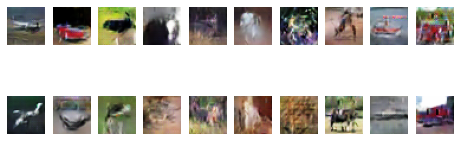

Epoch: 200 [D loss: 1.713230, acc.: 65.75%, op_acc: 55.75%] [G loss: 2.332740]
Uploading file: acgan.h5


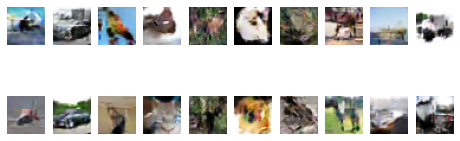

Epoch: 400 [D loss: 1.702933, acc.: 66.75%, op_acc: 54.55%] [G loss: 2.247144]
Uploading file: acgan.h5


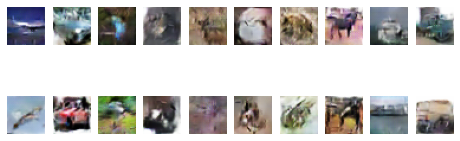

Epoch: 600 [D loss: 1.763056, acc.: 64.45%, op_acc: 53.45%] [G loss: 2.025161]
Uploading file: acgan.h5


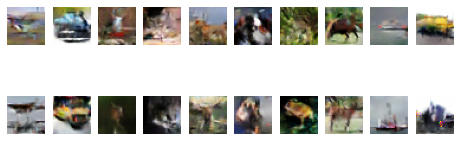

Epoch: 800 [D loss: 1.797026, acc.: 64.20%, op_acc: 50.45%] [G loss: 2.064367]
Uploading file: acgan.h5


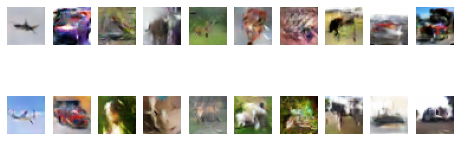

Epoch: 1000 [D loss: 1.798797, acc.: 62.00%, op_acc: 51.25%] [G loss: 2.050206]
Uploading file: acgan.h5


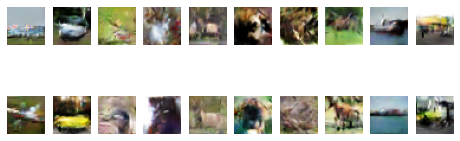

Epoch: 1200 [D loss: 1.823721, acc.: 62.70%, op_acc: 50.90%] [G loss: 2.150588]
Uploading file: acgan.h5


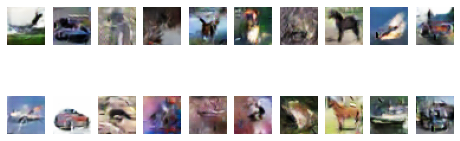

Epoch: 1400 [D loss: 1.738245, acc.: 65.10%, op_acc: 54.25%] [G loss: 2.139356]
Uploading file: acgan.h5


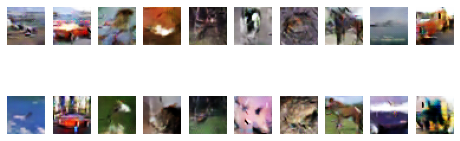

Epoch: 1600 [D loss: 1.762418, acc.: 64.30%, op_acc: 53.45%] [G loss: 2.202652]
Uploading file: acgan.h5


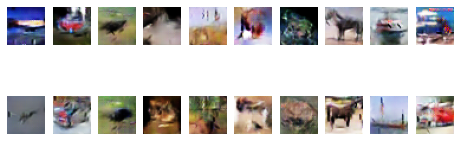

Epoch: 1800 [D loss: 1.724894, acc.: 63.30%, op_acc: 53.90%] [G loss: 2.000957]
Uploading file: acgan.h5


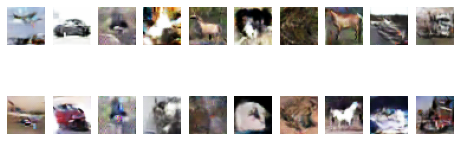

Epoch: 2000 [D loss: 1.784042, acc.: 63.70%, op_acc: 50.60%] [G loss: 2.173240]
Uploading file: acgan.h5


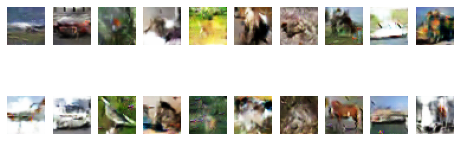

Epoch: 2200 [D loss: 1.798612, acc.: 60.80%, op_acc: 50.75%] [G loss: 2.161833]
Uploading file: acgan.h5


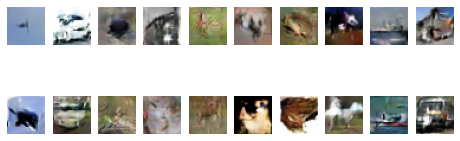

Epoch: 2400 [D loss: 1.759453, acc.: 63.10%, op_acc: 52.05%] [G loss: 2.279796]
Uploading file: acgan.h5


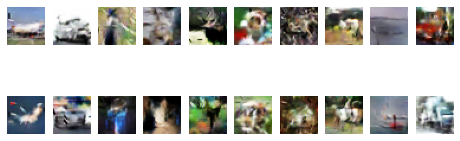

Epoch: 2600 [D loss: 1.802161, acc.: 62.80%, op_acc: 51.85%] [G loss: 2.133143]
Uploading file: acgan.h5


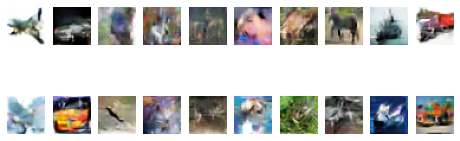

Epoch: 2800 [D loss: 1.753879, acc.: 62.20%, op_acc: 52.65%] [G loss: 2.211952]
Uploading file: acgan.h5


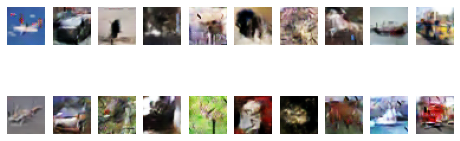

Epoch: 3000 [D loss: 1.799063, acc.: 61.05%, op_acc: 50.05%] [G loss: 2.183568]
Uploading file: acgan.h5


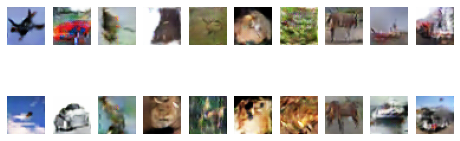

Epoch: 3200 [D loss: 1.795030, acc.: 61.95%, op_acc: 51.75%] [G loss: 2.238606]
Uploading file: acgan.h5


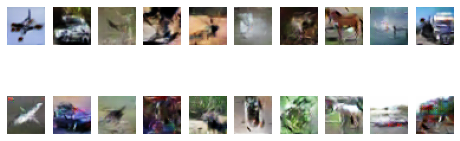

Epoch: 3400 [D loss: 1.762846, acc.: 64.45%, op_acc: 51.65%] [G loss: 2.189512]
Uploading file: acgan.h5


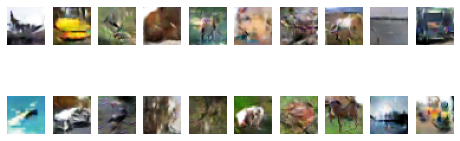

Epoch: 3600 [D loss: 1.770283, acc.: 61.95%, op_acc: 51.10%] [G loss: 2.216316]
Uploading file: acgan.h5


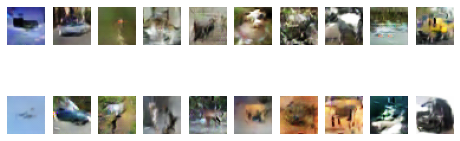

In [ ]:
g_loss, d_loss = ac_gan.train(X_train, y_train, epochs=50001, batch_size=1000, sample_interval=200)

In [ ]:
a = np.array([1,2,3,4,5])
ind = np.indices((5,))[0]
print(ind)
np.random.shuffle(ind)
print(ind)
print(a[ind])

[0 1 2 3 4]
[2 1 0 3 4]
[3 2 1 4 5]
